# Exercise Sheet 8: Optimization for Training Deep Models (Deadline: 06 Jan, 23:59)

In [11]:
# Set notebook to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

For theoretical tasks you are encouraged to write in $\LaTeX$. Jupyter notebooks support them by default. For reference, please have a look at the examples in this short excellent guide: [Typesetting Equations](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Typesetting%20Equations.ipynb)

Alternatively, you can upload the solutions in the written form as images and paste them inside the cells. But if you do this, **make sure** that the images are of high quality, so that we can read them without any problems.

### 0) Preamble : Understanding Gradient Signals of Activation functions (2.5 points)

In Assignment-5, we saw the importance of **activation functions** in action for achieving **non-linear** decision boundary. Because of this functionality/behaviour, these functions are sometimes called simply as **non-linearities** in Deep Learning literature. In this task, we will understand the gradient signals of three different non-linearities: *Sigmoid*, *Tanh*, and *ReLU*. 

(Find more information at: [Comparison_of_activation_functions](https://en.wikipedia.org/wiki/Activation_function#Comparison_of_activation_functions))

In [12]:
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

**i**) Implement the activation functions *Sigmoid*, *Tanh*, and *ReLU* and their gradient computation using only basic ops in TensorFlow (**1.5 point**)

(No need to derive the gradient expression, just use it as is (see the link above for help); You can use TensorFlow for stable implementations of $sigmoid$ and $tanh$ calculations. However, you **should do** the gradient computation yourself using *only* the basic ops such as `tf.nn.<activation_function>`, `tf.subtract`, `tf.square` etc.)

Unlike $\color{blue}{NumPy}$, TensorFlow doesn't have support for `float128` as of 2017. So, we will just stick to `tf.float64`.

In [13]:
# can be used to call .eval() on tensors
isess = tf.InteractiveSession()
one = tf.constant(1.0, dtype=tf.float64)
zero = tf.constant(0, dtype=tf.float64)
two = tf.constant(2.0, dtype=tf.float64)
# TODO: implement activation functions & their gradient computations

def sigmoid(x):
    """
    x: numpy array with the range of input values for our plot.
       should be `upcast`ed to float64, before taking sigmoid
    """
    x = tf.cast(x, tf.float64)
    return tf.div (one, (tf.add(one, tf.exp(-x))))


def sigmoid_grad(sigm):
    """
    sigm: compute gradient from the result of sigmoid.
          should be `upcast`ed to float64, before taking sigmoid
    """
    return tf.multiply(sigm, (tf.subtract(one, sigm)))

                       
def relu(x):
    """
    x: numpy array with the range of input values for our plot.
       should be `upcast`ed to float64, before taking relu
    """
    x = tf.cast(x, tf.float64)
    return tf.maximum(zero, x)


def relu_grad(rel):
    """
    rel: numpy array of `relu`ed values for the input
    return a boolean array of dtype `int`
    """
    return (rel >= zero)


def tanh(x):
    """
    x: numpy array with the `range` of input values for our plot.
    should be `upcast`ed to float64, before taking tanh
    """
    
    return tf.subtract(tf.div (two, (tf.add(one, tf.exp( -tf.multiply(two, x))))), one)


def tanh_grad(tnh):
    """
    tnh: numpy array of `tanh`ed values for the input
    """
    return tf.subtract(one, tf.square(tnh))

(ii) Plot the *gradient signals* of `Sigmoid`, `Tanh`, and `ReLU` activation functions overlaid in a single plot. (**0.5 points**) <br>
Use $200$ evenly spaced samples from the closed interval $[-10.0, 11.0]$ as the truncated [domain](https://en.wikipedia.org/wiki/Domain_of_a_function). <br>
$\color{green}{Hint}$: While plotting, set the $y-axis$ limit to $[0, 1.1]$ for better interpretation.

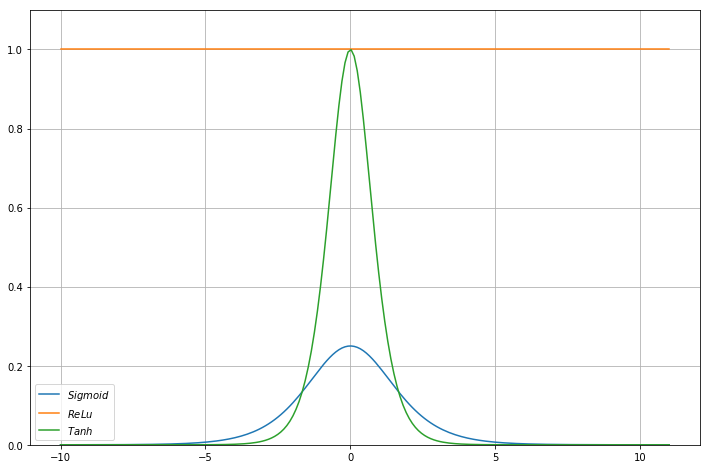

In [14]:
# TODO: implement plotting
samples = np.linspace(-10.0, 11.0, num=200)
init = tf.global_variables_initializer()
plt.ylim(0,1.1)
sig = sigmoid(samples).eval()
sig_der = sigmoid_grad(sig).eval()

rel = relu(samples).eval()
rel_der = relu_grad(rel).eval()

tnh = tanh(samples).eval()
tnh_der = tanh_grad(tnh).eval()

plt.plot(samples, sig_der, label="$Sigmoid$");
plt.plot(samples, rel_der, label="$ReLu$");
plt.plot(samples, tnh_der, label="$Tanh$");

plt.legend()
plt.grid()

**iii**) What do you observe from the plot? (**0.5 points**) <br>
$\color{red}{Note}:$ In addition to your own explanation, your solution should include how the *gradient signal* of one activation function differs from the other, over this truncated domain.

(It is *very important* to understand how these *gradient signals* behave and how one differs from the other. This understanding will be useful for the task below, and also later on when we talk about *RNNs*)

$\color{violet}{Ans}$: 
**Sigmoid Function:** Gradient towards either end of the sigmoid function, the Y values tend to respond very less to changes in X as we can see the gradient at that region is small. That means at that region, the gradient is small or has vanished (cannot make significant change because of the extremely small value). The network refuses to learn further or is drastically slow. It is called “vanishing gradients” problem. 

**Tanh Function:** Gradient is stronger for this function than sigmoid (derivatives are steeper). Hence optimization is easier in this method. But still it suffers from “vanishing gradients” problem.

**ReLu Function:** It avoids and rectifies “vanishing gradients” problem as Relu’s gradient is constant = 1. However for negative X, the gradient can go towards 0 (not visible in the truncated domain). It can cause a weight update which will makes it never activate on any data point again. That means ReLu could result in Dead Neurons.

# 1) Exploding/Vanishing Gradients (7.5 points)

In the lecture we've discussed some of the challenges in Neural Network Optimization. One among them is the so-called **Exploding/[Vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)** .

To be more specific, this problem happens only during the backward pass in training (very deep) Neural Networks.

**i**) Assume that you've a *100-layer* Feed Forward Neural Network with $sigmoid$ activation function as non-linearities. Explain mathematically why the *exploding or vanishing gradient problem* occurs only during the backward pass (and not during the forward pass) (**1 point**) .

$\color{green}{Hint}$: Think about what will happen to the *magnitude of gradient signal* when it reaches the first few layers (*i.e. layers near the input*), during *backpropagation*. The plot you did in *Preamble* section should also give you some intuition.


$\color{violet}{Ans}$: If we look at the gradient signals of sigmoid function the maximum is 1/4 ($\sigma'(0) = 1/4$). The range of the derivative of the cost function is always in $(0,1/4] $. In a 100-layer Feed Forward Neural Network, each neuron or “activity” is derived from the previous: it is the previous activity multiplied by some weight and then fed through an activation function. If we use the standard approach to initializing the weights in the network, then we'll choose the weights using Gaussian so the weights will usually satisfy $|w_j|<1$. While propagating the error through the network to update the weights, we apply chain rule such as 


$$ \frac{\partial error}{\partial w_1} = \frac{\partial error}{\partial output} * \frac{\partial output}{\partial hidden_{99}} * ... * \frac{\partial hidden_1}{\partial w_1}$$
If we take the last layer $ z_{100}= hidden_{99} * w_{100}$
$$\frac{\partial output}{\partial hidden_{99}} = \frac{\partial sigmoid(z_{100})}{\partial z_{100}} * w_{100}$$
The layer before the last one $ z_{99}= hidden_{98} * w_{99}$
$$\frac{\partial hidden_{99}}{\partial hidden_{98}} = \frac{\partial sigmoid(z_{99})}{\partial z_{99}} * w_{99}$$

so on so forth.
Now, look at the magnitude of the terms in our chain rule expression:

$\frac{\partial error}{\partial w_1} = \frac{\partial error}{\partial output} * \overbrace{\frac{\partial sigmoid(z_{100})}{\partial z_{100}}}^\text{<1/4} *  \overbrace{w_{100}}^\text{<1} \overbrace{\frac{\partial sigmoid(z_{99})}{\partial z_{99}}}^\text{<1/4} * \overbrace{w_{99}}^\text{<1}... * \frac{\partial hidden_1}{\partial w_1}$

As we've seen, the terms are typically less than 1/4 in magnitude. That means every time the gradient signal flows through a sigmoid gate, its magnitude always diminishes by one quarter (or more). As we backpropagate further back, we’d have many more small numbers in a product, creating an even tinier gradient. This problem occurs because of the gradient signals of sigmoid function. Since we do not need the derivative of sigmoid function during the forward pass, we only have it in the backward pass.


**ii**) Explain how we can avoid the problem of gradient explosion. Your explanation should talk about what we do with the *norm of the gradient*. (**1 point**) <br>
$\color{green}{Hint}$: You can consult the [DL-book](http://www.deeplearningbook.org/) & TensorFlow API docs for more information; Also, we expect the formula and its explanation in your solution.

$\color{violet}{Ans}$: We can avoid the problem of gradient explosion by **gradient clipping**(or norm-clipping). Basically, we prevent gradients from blowing up by rescaling them so that their norm is at most a particular value $n$. I.e., if $||g|| > n$, where g is the gradient, we set
$$ g \leftarrow \frac{ng}{||g||} $$ 
There are many instantiations of this idea (i.e. ||.|| could be L_2 norm) but the main concept is to limit the gradient to a maximum number and if the gradient exceeds that number, rescale the gradient parameters so the are limited within it. This customization retains the direction but limits the step size. 

##### iii) Vanishing Gradient Problem in Action (5.5 points)

In this part, you will implement a four layer FFN network in TensorFlow to (visually) understand the vanishing gradient problem.

In [15]:
# import libraries and data
import warnings
from sklearn.cross_validation import StratifiedShuffleSplit
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")
tf.reset_default_graph()

We'll be using MNIST dataset for this task, but not all 55K samples. Only a subset of 5K samples.

In [16]:
# read MNIST data
mnist = input_data.read_data_sets("data_MNIST/", one_hot=True)

Extracting data_MNIST/train-images-idx3-ubyte.gz
Extracting data_MNIST/train-labels-idx1-ubyte.gz
Extracting data_MNIST/t10k-images-idx3-ubyte.gz
Extracting data_MNIST/t10k-labels-idx1-ubyte.gz


In [17]:
# choose a subset of 5K samples (evenly distributed among all classes)

# extract zero-based indices of 1-hot locations in the array.
onehot_indices = [np.where(x==1)[0][0] for x in mnist.train.labels]
sss = StratifiedShuffleSplit(y=onehot_indices, n_iter=1, test_size=5000, random_state=0)

for _, subset_indices in sss:
    subset_images = mnist.train.images[subset_indices]
    subset_labels = mnist.train.labels[subset_indices]

In [18]:
# training set
train_images = subset_images
train_labels = subset_labels

print (train_labels.shape)

(5000, 10)


Implement a *four layer FF Neural Network* in TensorFlow, with first hidden layer size 50, second hidden layer size 50, third hidden layer size 50 (i.e. 50 hidden units), and output layer size corresponding to the size of `num_labels`. Specifically, the network will be: `inputs->hidden1->hidden2->hidden3->output`

$\color{red}{Note}$: $\star$ Initialize the weight matrices using [Xavier initialization](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer). Biases can be initialized with [zeros](https://www.tensorflow.org/api_docs/python/tf/zeros). <br>
$\hspace{2em}$ $\star$ Use `tf.float32` for all tensors, for faster computation. <br>
$\hspace{2em}$ $\star$ Use **sigmoid activation** function as the non-linearity. <br>
$\hspace{2em}$ $\star$ Use $L_2$ regularization (i.e. weight decay) with alpha ($\alpha$) value of *1e-6*. See [tf-api](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss) for more details. <br>
$\hspace{2em}$ $\star$ Use *softmax cross entropy* as the loss function as in Assignment-5. (Note that, generally, this is used only during training time.)<br>
$\hspace{2em}$ $\star$ Use `Gradient Descent Optimizer` with learning rate of 0.5<br>
$\hspace{2em}$ $\star$ Here we are doing *batch training* (i.e. we use all 5K samples at once).<br>

$\color{green}{Hint}$: To understand how the *gradient magnitude (of weights)* changes during training, we need the gradients for the *weights*. Look into [tf-processing-gradients](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer#processing_gradients_before_applying_them) for help.

With these in mind, now build the computation graph of our model below. (**1.5 points**)

In [19]:
# TODO: Implement
    
def model(input_shape, output_shape, n_hidden_units, x):
    W1 = tf.get_variable('weights-hidden1', shape=[input_shape[1], n_hidden_units], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('biases-hidden1', shape=[n_hidden_units], dtype=tf.float32, initializer=tf.zeros_initializer())
    a1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)
    
    W2 = tf.get_variable('weights-hidden2', shape=[n_hidden_units, n_hidden_units], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('biases-hidden2', shape=[n_hidden_units], dtype=tf.float32, initializer=tf.zeros_initializer())
    a2 = tf.nn.sigmoid(tf.matmul(a1, W2) + b2)
    
    W3 = tf.get_variable('weights-hidden3', shape=[n_hidden_units, n_hidden_units], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('biases-hidden3', shape=[n_hidden_units], dtype=tf.float32, initializer=tf.zeros_initializer())
    a3 = tf.nn.sigmoid(tf.matmul(a2, W3) + b3)
    
    W4 = tf.get_variable('weights-output', shape=[n_hidden_units, output_shape[1]], dtype=tf.float32, initializer=tf.random_normal_initializer())
    b4 = tf.get_variable('biases-output', shape=[output_shape[1]], dtype=tf.float32, initializer=tf.zeros_initializer())
    a4 = tf.matmul(a3, W4) + b4
    return W1, W2, W3, W4, b1, b2, b3, b4, a4


# hparams
# ---------
# parameter for regularization.
alpha = 1e-6

# learning rate
lr = 0.5

# TODO: Implement
g = tf.Graph()

with g.as_default():
    n_hidden_units = 50
    input_shape = (None,train_images.shape[1])
    output_shape = (None,train_labels.shape[1])
    
    x = tf.placeholder(tf.float32, shape=input_shape, name='X')
    y = tf.placeholder(tf.float32, shape=output_shape, name='y')
    
    W1, W2, W3, W4, b1, b2, b3, b4, unscaled_logits = model(input_shape, output_shape, n_hidden_units, x)
    predictions = tf.nn.sigmoid(unscaled_logits)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=unscaled_logits))
    regularizers = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)+ tf.nn.l2_loss(W3)+ tf.nn.l2_loss(W4)
    loss = loss + alpha * regularizers

    # Accuracy
    accuracy = compute_accuracy(predictions, y)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(lr)
    variables = [W1, W2, W3, W4, b1, b2, b3, b4]
    grads_and_vars = optimizer.compute_gradients(loss, variables)
    grads = [(gv[0]) for gv in grads_and_vars]
    step = optimizer.apply_gradients(grads_and_vars)

    init = tf.global_variables_initializer()
    


Implement the function below which computes accuracy. (**0.5 points**)

In [20]:
# TODO: Implement
def compute_accuracy(predictions, ground_truth):
    model_prediction = tf.greater_equal(predictions, 0.5)
    model_prediction = tf.cast(model_prediction, tf.float32)
    correct_prediction = tf.equal(model_prediction, ground_truth)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    """
    compute & return accuracy (in percentage).
    predictions: predictions from the network
    ground_truth: 1-hot array of ground truth labels
    """
    return accuracy

Implement code which performs network training (with `num_steps = 3001`). (**1.5 point**) <br>
$\color{green}{Hint}$: To understand how the *gradient magnitude (of weights)* (i.e. their absolute values) changes across layers and with each of the 3K steps, we need to cache the *mean of absolute value of gradients (of weights)* of all 4 layers in each step of the total 3K steps. We'll need these gradients for plotting later on.

In [21]:
# TODO: implement network training
w1_list = []
w2_list = []
w3_list = []
w4_list = []

epochs = 3001
# Start a Session 
with tf.Session(graph=g) as sess:
    # Initialize all variables
    sess.run(init)
    for epoch in range(epochs):
        # Shuffle training data
        indices = list(range(len(train_images)))
        feed_dict = {x: train_images[indices], y: train_labels[indices]}
        sess.run(step, feed_dict=feed_dict)
        acc = sess.run(accuracy, feed_dict=feed_dict)
        
        gradients = sess.run(grads, feed_dict=feed_dict)
        mean_w1 = np.mean(np.absolute(gradients[0].flatten()))
        w1_list.append(mean_w1)
        mean_w2 = np.mean(np.absolute(gradients[1].flatten()))
        w2_list.append(mean_w2)
        mean_w3 = np.mean(np.absolute(gradients[2].flatten()))
        w3_list.append(mean_w3)
        mean_w4 = np.mean(np.absolute(gradients[3].flatten()))
        w4_list.append(mean_w4)
        
        # Print accuracy
        if epoch % 100 == 0:
            print('Epoch: {:d}, Training Accuracy: {:.2f}'.format(epoch, acc))
    
    
# 
# TODO: cache the mean of absolute value of gradients
#
# TODO: print stats for every 100 steps


Epoch: 0, Training Accuracy: 0.60
Epoch: 100, Training Accuracy: 0.90
Epoch: 200, Training Accuracy: 0.90
Epoch: 300, Training Accuracy: 0.90
Epoch: 400, Training Accuracy: 0.90
Epoch: 500, Training Accuracy: 0.90
Epoch: 600, Training Accuracy: 0.91
Epoch: 700, Training Accuracy: 0.92
Epoch: 800, Training Accuracy: 0.93
Epoch: 900, Training Accuracy: 0.94
Epoch: 1000, Training Accuracy: 0.94
Epoch: 1100, Training Accuracy: 0.95
Epoch: 1200, Training Accuracy: 0.95
Epoch: 1300, Training Accuracy: 0.95
Epoch: 1400, Training Accuracy: 0.95
Epoch: 1500, Training Accuracy: 0.96
Epoch: 1600, Training Accuracy: 0.96
Epoch: 1700, Training Accuracy: 0.96
Epoch: 1800, Training Accuracy: 0.97
Epoch: 1900, Training Accuracy: 0.97
Epoch: 2000, Training Accuracy: 0.97
Epoch: 2100, Training Accuracy: 0.97
Epoch: 2200, Training Accuracy: 0.97
Epoch: 2300, Training Accuracy: 0.97
Epoch: 2400, Training Accuracy: 0.97
Epoch: 2500, Training Accuracy: 0.97
Epoch: 2600, Training Accuracy: 0.98
Epoch: 2700, 

Train the network for 3K steps. Print the *loss* and *training accuracy* after every 100 steps. <br> (This will be helpful as a sanity check for your implementation and also for the later analysis question) <br>
$\color{green}{Hint}$: If you implement it correctly, and train it for 3K steps with the provided hyperparameters, the execution time on a 4GB machine would be *ca. 12 mins*, and the *training accuracy* would be around 99.9%. Also, here we're doing only training; i.e. no validation and testing.

**iv**) **Plotting**

Now, plot the value of gradient magnitudes of all 4 layers, overlaid in a single plot. (**1 point**) <br>
$\color{green}{Hint}$: Your $x-axis$ should be $\#steps$ and $y-axis$ should have the *mean value of gradient magnitudes (of weights)* corresponding to all 4 layers.

$\color{red}{Note}$: The important part of this exercise is the plot that explains the *vanishing gradient problem* and the observations that you make out of it.

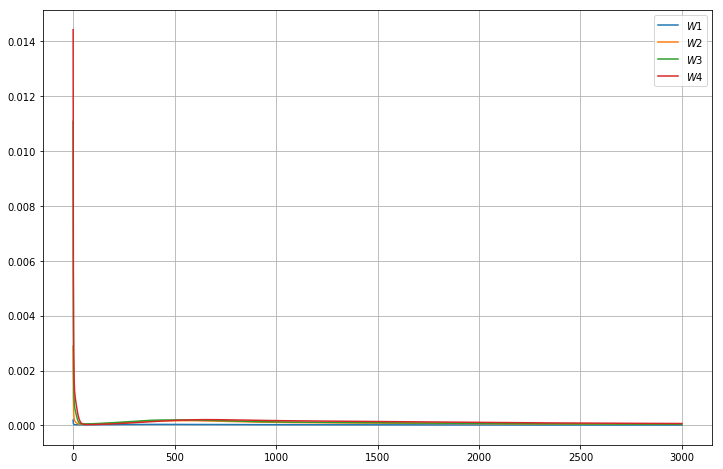

In [22]:
# TODO: implement plotting
#
# 

steps = np.arange(epochs)
plt.plot(steps, w1_list, label="$W1$");
plt.plot(steps, w2_list, label="$W2$");
plt.plot(steps, w3_list, label="$W3$");
plt.plot(steps, w4_list, label="$W4$");
plt.legend()
plt.grid()

Q1) What are your observations from the above plot? How does the *flow of gradient signal* through different layers changes with the increase in number of steps (during training)? (**0.5 points**)

$\color{violet}{Ans}$: The mean values of gradient magnitudes start decreasing from for W4 = .015,  W3 = .011, W2 = .003, W1 = .00 (almost none).
While the change in the last layer (W4) very big (.014), in the first layer the change is so close to 0. It is obvious that the gradient signal is exponentially decreasing with the increase in number of steps. This causes that while W4 is adaptated very well within the first steps, W1 remains almost the same during the whole training.  

Q2) Now, analyze the *training accuracy & loss values* from the stats of the whole training loop. At the same time (in parallel), observe from the plot how the gradient signal(magnitude) changes across layers as the steps increase. *Relate these two observations* and explain your findings. (**0.5 points**) <br>

$\color{violet}{Ans}$: For the first 100 steps the accuracy shows remarkable improvement, at the same time the gradient signals of the layers decrease instantly. Between 700 - 1500 steps the accuracy improves but so slowly and we can see the changes in the gradient signals which are very small. After 2000 steps the accuracy doesn't improve at all and correspondently the gradient signals of the weights are almost 0. So we can understand that in the last 1000 steps, we reached the tails of the gradient of the sigmoid function therefore cannot make significant improvement because of the extremely small value. 

# 2) Understanding Optimization Algorithms (10 points)

### Optimization algorithms for Deep Neural Networks

In this task, you will study and understand various optimization methods such as *Vanilla Gradient Descent, Gradient Descent with Momentum, AdaGrad, Adam, and RMSProp*. <br>
For a terse & high level overview of these algorithms, see here: [SGD-variants](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Extensions_and_variants)

$\color{red}{Note}$: Adam was *not introduced* in the lecture but it's an important algorithm to know, particularly for NLP & Computer Vision problems. Refer [section 8.5.3](http://www.deeplearningbook.org/contents/optimization.html) for details. <br>

#### 1) Stochastic Gradient Descent (SGD) Optimizer (2 points)

i) Is it important to use *learning rate decay* for (mini-batch) SGD based learning? Justify. (**0.5 + 1 points**) <br>
ii) What is the advantage of using a *small batch size* during training instead of the *full set of examples at once* in the training data? (**0.5 points**)

$\color{violet}{Ans}$:

i) It is important to use learning rate decay in (mini-batch) SGD, else the algorithm may miss/overshoot the (local) optimum and as a consequence fluctuate around the minimum or diverge. This stems from the fact that the random sampling of m training examples introduces noise that does not vanish even when arriving at a minimum. <br>
ii) The advantage of using small batch size is that in this way the model is implicitly regularized. Another advantage is that this approach does not cause problems with cache memory limits. The advantage of using batches/SGD at all is that compared with Batch gradient descent it converges more quickly and is allowed to incorporate new training examples in a so-called online fashion. 

#### 2) Momentum Optimizer (2 points)

Familiarize yourself with the algorithm from the lecture slide and [DL book](http://www.deeplearningbook.org/contents/optimization.html) and understand how it works.<br>
i) Now describe, in what way Momentum method is different from *vanilla SGD*? (**1 point**)

ii) It is known that the cost function of NNs usually has many saddle points. How does momentum method help to alleviate the problem of getting stuck in these saddle points when compared to vanilla SGD? (**1 point**) <br>
$\color{red}{Note}$: You can assume that, in both cases, we start at the same initial point.

$\color{violet}{Ans}$:

i) In contrast to vanilla SGD, Momentum accumulates in $v$ the gradient elements from the previous iterations. <br>
$v = \alpha v - \triangledown_{\theta} \left( \frac{1}{m} \sum^{m}_{i=1}L(f(x^{(i)}; \theta), y^{(i)})\right)\\
\theta = \theta + v$ <br>
The momentum term increases for dimensions whose gradients point in the same directions as at previous iterations and reduces the updates for dimensions whose gradients change directions. In this way Momentum can handle ravines and dampen oscillations as well as accelerate convergence.
<br>
ii) Momentum would be able to recover from entering a saddle point because it can be formuleted as the interdependance of two forces. The first takes into account the direction of the previous gradients and accelerates proportionally to the negative gradient of the cost function $-\triangledown_{\theta}J(\theta)$. The second is opposed to it and proportional to $-v(t)$; it corresponds to viscous drag in physics terminology and acts as a "friction" slowing down movement in certain direction. "Viscous drag is weak enough that the gradient can continue to cause motion until a minimum is reached, but strong enough to prevent motion if the gradient does not justify moving" (DL book, p.299). In this case when reaching a saddle point, the algorithm will first go back and forth in one direction, dampening the progress. If there has consistently been positive progress in another direction, it ends up building up and going down that way.

#### 3) AdaGrad optimizer (2 points)

Further reading: [Adaptive SubGradient Methods for Stochastic Optimization](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

$\color{red}{Note}$: An important algorithm for NN training for NLP and CV problems.

Refer the slides and the [DL book](http://www.deeplearningbook.org/contents/optimization.html) and understand how AdaGrad algorithm works.  <br>
i) Describe the basic idea behind AdaGrad algorithm. (**1 point**) <br>
ii) What is the disadvantage of this algorithm, in practice? (**0.5 points**)<br>
iii) What is the important property of this algorithm? (**0.5 points**)

$\color{violet}{Ans}$:  <br>
i)  The basic idea behind AdaGrad is that the learning rate adapts based on the parameters in such way, that it decreases for more frequent parameters and increases for rarer ones. This is an advantage especially in settings where data is sparse and sparse parameters are more informative. <br>
ii) The learning rate decreases monotonically (as the term $\frac{\eta}{\sqrt{G_{j,j}+\epsilon}}$ accumulates the squared gradients in the denominator and their sum grows) to a point where the algorithm stops learning. 
<br>
iii) One important property of the algorithm is that the learning rate adapts automatically and does not need to be adapted manually. Moreover, as already mentioned, the algorithm distinguishes between more and less sparse parameters and updates them accordingly.<br>

##### 4) RMSProp optimizer (2 points)

i) How does RMSProp differ from AdaGrad?  (**1 point**) <br>
ii) What disadvantage(s) in AdaGrad are solved by RMSProp? Explain it using the formula. (**1 point**)

$\color{violet}{Ans}$:  <br>
i)  <br> The $g_t $ term is calculated by exponentially decaying average and not the sum of gradients.

ii) <br> When the gradient is very large, alpha is reduced and vice-versa. 
$g_(t+1)=γg_t+(1−γ)δL(θ)^2$

Here $g_t$ is called the second order moment of δL.Additionally, a first order moment $ m_t $ can also be introduced.
$m_(t+1)=γm_t+(1−γ)δL(θ)$

$g_(t+1)=γg_t+(1−γ)δL(θ)^2$

Adding momentum as in the first case,
$v_(t+1)=μvt−\frac{αδL(θ)}{\sqrt{g_(t+1)−m_(t+1)^2+ϵ}} $
And finally collecting new theta 
$θ_(t+1)=θ_t+v_(t+1)$



#### 5) Adam Optimizer (2 points)

Further reading: [ADAM: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980.pdf)

$\color{red}{Note}$: Adam was *not introduced* in the lecture but it's an important algorithm to know, particularly for NLP & Computer Vision problems. Refer [section 8.5.3](http://www.deeplearningbook.org/contents/optimization.html) for details. <br>

i) Is there any similarity between RMSProp and Momentum? Is it possible to combine them? (**1 point**)

ii) Describe the way in which Adam algorithm performs parameter update.<br>
What are the advantage(s) of such an update rule when compared to RMSProp (with momentum)? (**1 point**)

$\color{violet}{Ans}$:  <br>
i)  <br> RMSProp and Momentum try to adjust the step size so that the step is on the same scale as the gradients - as the average gradient gets smaller, the coefficient in the SGD update gets bigger to compensate.

To combine them,we could add the momentum, and normalize the learning rate using the moving average squared gradient.
    
ii) <br>Adam algorithm computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.
Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).
Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

Compared to RMSProp,it achieves good results fast.Its bias-correction helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser.

# Christmas Bonus (1 point)

Where and how could you apply a deep neural network for ensuring safety of humans during Christmas & New Year celebrations?

1.Real-time analysis of behaviors to find the weird actions of terrorist when there is a crow of  person to avoid terrorist attack。

2.Understand an event with videos of differt perspectives after some accidents and could provide the process of how it has happened.

3.After the festival, many people drive back to the big city to work, so on the high way,the auto driving could help release the burden of car flow.

-----------------------------------------------------------------------------------------------

# $\color{red}{\star \star We\hspace{0.5em}Wish\hspace{0.5em}You\hspace{0.5em}a\hspace{0.5em}Merry\hspace{0.5em}Christmas! \star \star} $ $\color{violet}{\&}$ $\color{green}{Happy\hspace{0.5em}New\hspace{0.5em}Year!} $ - NNIA Team

--------------------------------------------------------------------------

## Submission instructions
You should provide a single Jupyter notebook as the solution. The naming should include the assignment number and matriculation IDs of all members in your team in the following format:
**assignment-8_matriculation1_matriculation2_matriculation3.ipynb** (in case of 3 members in a team). 
Make sure to keep the order matriculation1_matriculation2_matriculation3 the same for all assignments.

Please submit the solution to your tutor (with **[NNIA][assignment-8]** in email subject):
1. Maksym Andriushchenko <s8mmandr@stud.uni-saarland.de>
2. Marius Mosbach <s9msmosb@stud.uni-saarland.de>
3. Marimuthu Kalimuthu <s8makali@stud.uni-saarland.de>
4. Rajarshi Biswas <rbisw17@gmail.com>

Note :  **If you are in a team, you should submit only 1 solution to only 1 tutor.** <br>
$\hspace{2em}$ **Submissions violating these rules will not be graded.**